<a href="https://colab.research.google.com/github/Subikesh/Sentiment-Analysis/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In this project we'll get the dataset containing the reviews from amazon for baby products and their corresponding ratings given by the users. 
We will clean the unstructured reviews to structured data by One-hot encoding.
We will train many classification models on the dataset and analyse the sentiment for each reviews.
And finally, we will find the best model by creating an accuracy table.

In [0]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns',5)

# Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The dataset amazon-baby.csv contains a larger dataset than the one used here. This is used because the algorithms takes lot of time in the larger dataset.

In [3]:
# amazon_data = pd.read_csv('/content/gdrive/My Drive/colab_input/amazon_baby.csv')
amazon_data = pd.read_csv('/content/gdrive/My Drive/colab_input/amazon_baby_subset.csv')
amazon_data.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


Number of reviews for each rating in the dataset is shown below. Since this is a compact version of the original dataset, all the reviews with rating 3 are removed.

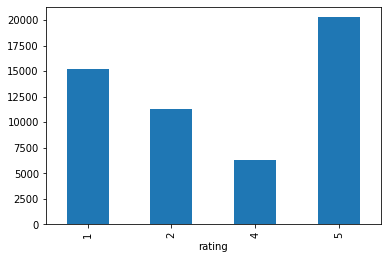

In [4]:
amazon_data.groupby('rating').size().plot.bar()

## Cleaning Data

Let's create a sentiment column with sentiments as per the ratings given and remove all the reviews with rating 3 because rating with 3 stars cannot be considered as positive or negative review.

In [5]:
print('Data before droping ', amazon_data.shape)
amazon_data = amazon_data[amazon_data['rating'] != 3]
print("Data after droping rows", amazon_data.shape)

Data before droping  (53072, 4)
Data after droping rows (53072, 4)


In [6]:
amazon_data['sentiment'] = amazon_data['rating'].apply(lambda r: +1 if r>3 else -1)
amazon_data.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [7]:
# Droping unwanted features to clean up space
amazon_data = amazon_data.drop(columns = ['rating', 'name'])
amazon_data.head()

,review,sentiment
0,All of my kids have cried non-stop when I trie...,1
1,We wanted to get something to keep track of ou...,1
2,My daughter had her 1st baby over a year ago. ...,1
3,"One of baby's first and favorite books, and it...",1
4,Very cute interactive book! My son loves this ...,1


The important words from the reviews are taked as a json file, so that those features can be used to calculate the sentiment

In [8]:
import json
with open('/content/gdrive/My Drive/colab_input/important_words.json', 'r') as f:
    important_words = json.load(f)
important_words = [str(s) for s in important_words]
print(len(important_words), "words imported from json")

193 words imported from json


In [9]:
import string 

# Removing the punctuations from the reviews so there wont be any problem in retrieving the words
def remove_punctuations(text):
    translator = text.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

amazon_data = amazon_data.dropna()
amazon_data['clean_review'] = amazon_data['review'].apply(remove_punctuations)
clean_data = amazon_data.drop('review', axis=1)
clean_data.head()

,sentiment,clean_review
0,1,All of my kids have cried nonstop when I tried...
1,1,We wanted to get something to keep track of ou...
2,1,My daughter had her 1st baby over a year ago S...
3,1,One of babys first and favorite books and it i...
4,1,Very cute interactive book My son loves this b...


## Encoding for classification
Creating features for important words from the *clean_review* column so they 
can be used for creating the models.

In [10]:
for word in important_words:
    clean_data[word] = clean_data['clean_review'].apply(lambda text: text.split().count(word))
final_data = clean_data.drop('clean_review', 1)
final_data.head(), final_data.shape

(   sentiment  baby  ...  almost  either
 0          1     0  ...       0       0
 1          1     0  ...       0       0
 2          1     1  ...       0       0
 3          1     0  ...       0       0
 4          1     0  ...       0       0
 
 [5 rows x 194 columns], (52831, 194))

## Splitting train and test data


In [11]:
from sklearn.model_selection import train_test_split
X = final_data[important_words]
y = final_data['sentiment']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)
train_X.shape, test_X.shape

((42264, 193), (10567, 193))

# Training models

## Import libraries

We are using the following algorithms for predicting the sentiment:


*   [Logistic Regression](#logistic-regression)
*   [Decision Tree](#decision-trees)
*   [K-Nearest neighbors](#k-nearest-neighbors) 
*   [Support Vector Machine](#support-vector-machine)


_Though decision trees are not a good model for calculation of more than 100 equally important features, we are just using it to see the difference in accuracy between other algorithms._

In [0]:
# Models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

An **accuracy table** is created which holds the values of accuracies of all the models trained.This table will be revealed after training all the models, just to keep up the suspence.<br>
A utility function is created to calculate the metrics for each model and add it to the accuracy table.



In [0]:
accuracy_table = pd.DataFrame(columns=['precision_score','recall_score', 'f1_score', 'accuracy_score'])

def append_accuracy(model, prediction, true_val, label):
    acc = []
    acc.append(precision_score(prediction, true_val))
    acc.append(recall_score(prediction, true_val))
    acc.append(f1_score(prediction, true_val))
    acc.append(accuracy_score(prediction, true_val))
    accuracy_table.loc[label] = acc

## Logistic Regression


In [14]:
params = {'C': [0.001, 0.01, 0.1, 1, 10]}
# This also applies 10 fold cross-validation
model = GridSearchCV(LogisticRegression(solver='liblinear', random_state=1),param_grid=params, cv=10)
model.fit(train_X, train_y)

print("Chosen parameter :", model.best_params_)
print("Best cross-validation score :{:.3f}".format(model.best_score_))

Chosen parameter : {'C': 0.1}
Best cross-validation score :0.792


In [15]:
# finding the model accuracy and adding it to the table
predictions = model.predict(test_X)
append_accuracy(model, predictions, test_y, "Logistic Regression")
cm_log_reg = confusion_matrix(predictions, test_y)
cm_log_reg

array([[4153, 1156],
       [1075, 4183]])

## Decision Trees

In [16]:
params = {'max_leaf_nodes': [100, 200, 250, 300]}
model = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid=params)
model.fit(train_X, train_y)

print("Chosen parameter :", model.best_params_)
print("Best accuracy score :{:.3f}".format(model.best_score_))

Chosen parameter : {'max_leaf_nodes': 250}
Best accuracy score :0.742


In [17]:
predictions = model.predict(test_X)
append_accuracy(model, predictions, test_y, "Decision Tree")
cm_dec_tree = confusion_matrix(predictions, test_y)
cm_dec_tree

array([[4051, 1443],
       [1177, 3896]])

## K-Nearest Neighbors

In [18]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(train_X, train_y)

print("Model Created")

Model Created


Prediction of the KNN model takes a long time since this should calculate the distances between each points and find K neighbors around it.

In [19]:
predictions = model.predict(test_X)
append_accuracy(model, predictions, test_y, "K-nearest neighbors")
cm_KNN = confusion_matrix(predictions, test_y)
cm_KNN

array([[3218, 1328],
       [2010, 4011]])

## Support Vector Machine

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(train_X)
train_X = scaling.transform(train_X)
test_X = scaling.transform(test_X)

Training this model might take some time. We are normalising the data so that the values are between [-1, 1]. *Just sit back and relax.* ;)

In [21]:
model = SVC(kernel='rbf', gamma='auto', random_state=1)
model.fit(train_X, train_y)

print("Model created")

Model created


In [22]:
predictions = model.predict(test_X)
append_accuracy(model, predictions, test_y, "Support vector machine")
cm_SVM = confusion_matrix(predictions, test_y)
cm_SVM

array([[3837, 1017],
       [1391, 4322]])

# Final Accuracy table

Let's reveal the accuracy table from all the models calculated above and let's see which model performs the best on the test data.

In [23]:
accuracy_table

,precision_score,recall_score,f1_score,accuracy_score
Logistic Regression,0.783480,0.795550,0.789469,0.788871
Decision Tree,0.729725,0.767987,0.748367,0.752058
K-nearest neighbors,0.751264,0.666168,0.706162,0.684111
Support vector machine,0.809515,0.756520,0.782121,0.772121


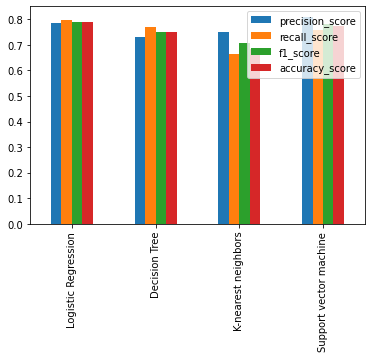

In [25]:
accuracy_table.plot.bar()

## Inference

### Observations:

1.   Surpricingly K-nearest neighbor performs worst among all. It's performance may be optimised by tuning it's hyperparameters, which is not done here because it takes lot of time for prediction.
2.   It is clear that decision trees are not good for sentiment analysis, since decision trees cannot make a good model with lots of features with equal importance.
3.   Though SVM should do better for high dimensional data, logistic regression performs better in this dataset. 

Thus, we can infer that the model **Logistic Regression** does the best on the test data, followed by **SVM**.


---


